In [1]:
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pandas as pd

In [2]:
def display_scores(results):
   mean = np.mean(results)
   sigma = scipy.stats.sem(results)
   sigma = sigma * scipy.stats.t.ppf((1 + 0.95) / 2., 5-1)
  #  sigma = 1.96*(np.std(results)/np.sqrt(len(results)))
   print('Final Score: ', f'{mean} \xB1 {sigma}')


def train_test_divide (data_x, data_x_hat, data_t, data_t_hat, train_rate=0.8):
  """Divide train and test data for both original and synthetic data.

  Args:
    - data_x: original data
    - data_x_hat: generated data
    - data_t: original time
    - data_t_hat: generated time
    - train_rate: ratio of training data from the original data
  """
  # Divide train/test index (original data)
  no = len(data_x)
  idx = np.random.permutation(no)
  train_idx = idx[:int(no*train_rate)]
  test_idx = idx[int(no*train_rate):]

  train_x = [data_x[i] for i in train_idx]
  test_x = [data_x[i] for i in test_idx]
  train_t = [data_t[i] for i in train_idx]
  test_t = [data_t[i] for i in test_idx]

  # Divide train/test index (synthetic data)
  no = len(data_x_hat)
  idx = np.random.permutation(no)
  train_idx = idx[:int(no*train_rate)]
  test_idx = idx[int(no*train_rate):]

  train_x_hat = [data_x_hat[i] for i in train_idx]
  test_x_hat = [data_x_hat[i] for i in test_idx]
  train_t_hat = [data_t_hat[i] for i in train_idx]
  test_t_hat = [data_t_hat[i] for i in test_idx]

  return train_x, train_x_hat, test_x, test_x_hat, train_t, train_t_hat, test_t, test_t_hat


def extract_time (data):
  """Returns Maximum sequence length and each sequence length.

  Args:
    - data: original data

  Returns:
    - time: extracted time information
    - max_seq_len: maximum sequence length
  """
  time = list()
  max_seq_len = 0
  for i in range(len(data)):
    max_seq_len = max(max_seq_len, len(data[i][:,0]))
    time.append(len(data[i][:,0]))

  return time, max_seq_len


def visualization(ori_data, generated_data, analysis, compare=3000):
    """Using PCA or tSNE for generated and original data visualization.

  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca or kernel
  """
    # Analysis sample size (for faster computation)
    anal_sample_no = min([compare, ori_data.shape[0]])
    idx = np.random.permutation(ori_data.shape[0])[:anal_sample_no]

    # Data preprocessing
    # ori_data = np.asarray(ori_data)
    # generated_data = np.asarray(generated_data)

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    no, seq_len, dim = ori_data.shape

    for i in range(anal_sample_no):
        if (i == 0):
            prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, seq_len])
            prep_data_hat = np.reshape(np.mean(generated_data[0, :, :], 1), [1, seq_len])
        else:
            prep_data = np.concatenate((prep_data,
                                        np.reshape(np.mean(ori_data[i, :, :], 1), [1, seq_len])))
            prep_data_hat = np.concatenate((prep_data_hat,
                                            np.reshape(np.mean(generated_data[i, :, :], 1), [1, seq_len])))

    # Visualization parameter
    colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components=2)
        pca.fit(prep_data)
        pca_results = pca.transform(prep_data)
        pca_hat_results = pca.transform(prep_data_hat)

        # Plotting
        f, ax = plt.subplots(1)
        plt.scatter(pca_results[:, 0], pca_results[:, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(pca_hat_results[:, 0], pca_hat_results[:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

        ax.legend()
        plt.title('PCA plot')
        plt.xlabel('x-pca')
        plt.ylabel('y_pca')
        plt.show()

    elif analysis == 'tsne':

        # Do t-SNE Analysis together
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)

        # TSNE anlaysis
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, max_iter=300)
        tsne_results = tsne.fit_transform(prep_data_final)

        # Plotting
        f, ax = plt.subplots(1)

        plt.scatter(tsne_results[:anal_sample_no, 0], tsne_results[:anal_sample_no, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(tsne_results[anal_sample_no:, 0], tsne_results[anal_sample_no:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

        ax.legend()

        plt.title('t-SNE plot')
        plt.xlabel('x-tsne')
        plt.ylabel('y_tsne')
        plt.show()

    elif analysis == 'kernel':

        # Visualization parameter
        # colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]

        f, ax = plt.subplots(1)
        sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
        sns.distplot(prep_data_hat, hist=False, kde=True, kde_kws={'linewidth': 5, 'linestyle':'--'}, label='Synthetic', color="blue")
        # Plot formatting

        # plt.legend(prop={'size': 22})
        plt.legend()
        plt.xlabel('Data Value')
        plt.ylabel('Data Density Estimate')
        # plt.rcParams['pdf.fonttype'] = 42

        # plt.savefig(str(args.save_dir)+"/"+args.model1+"_histo.png", dpi=100,bbox_inches='tight')
        # plt.ylim((0, 12))
        plt.show()
        plt.close()

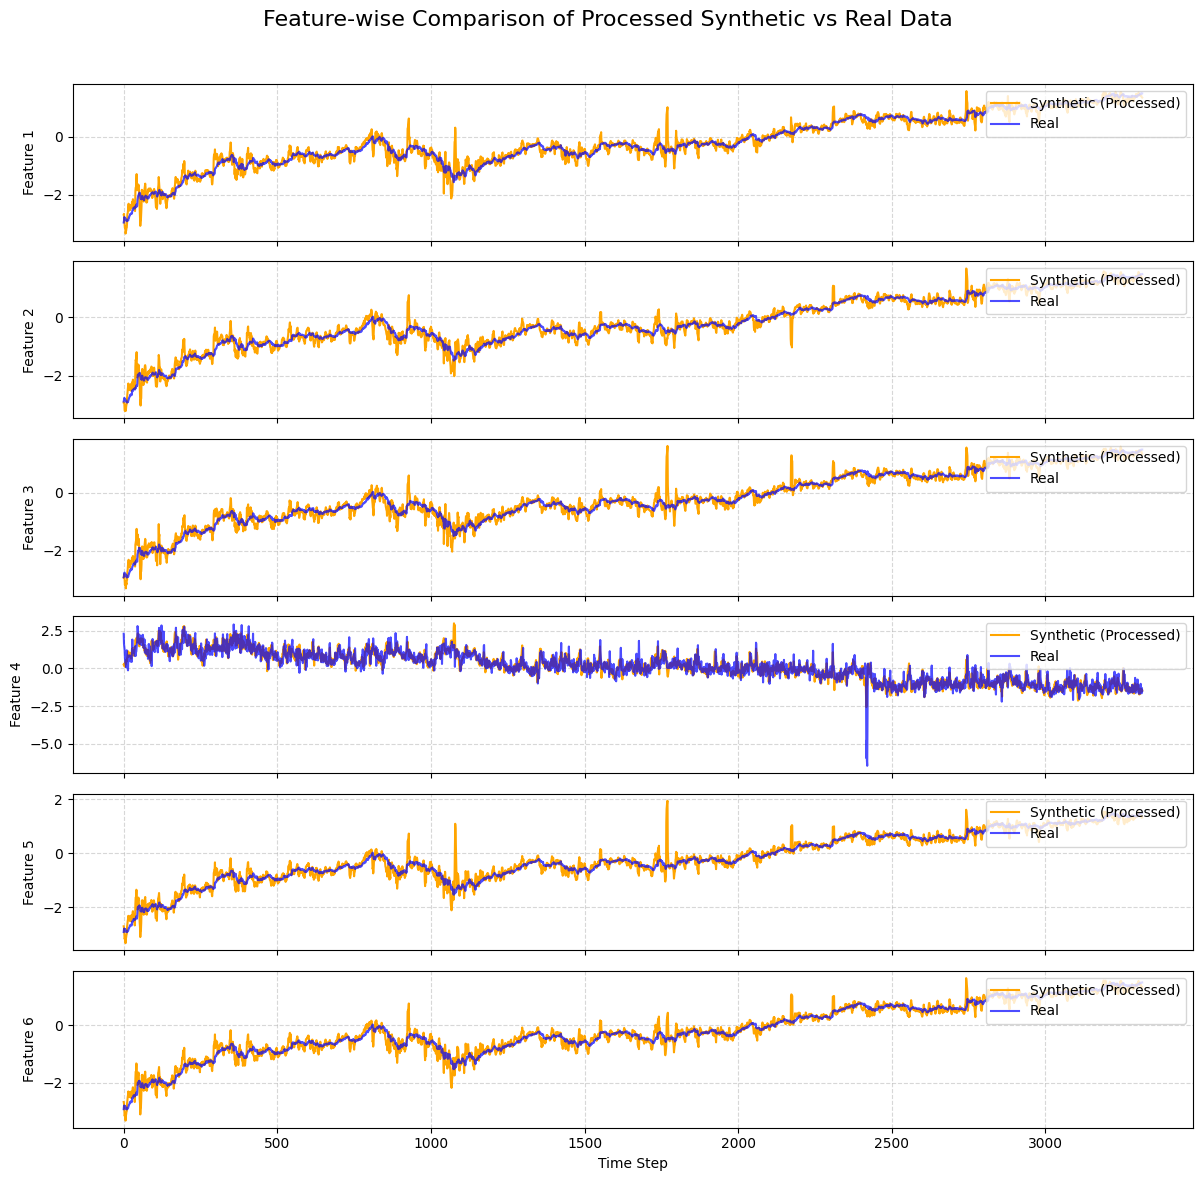

In [ ]:
# ==== Load the denorm_smoothed_rescaled data ====
processed_syn = np.load("")
real_data = np.load("")[0][:processed_syn.shape[0]]

n_features = processed_syn.shape[1]

# ==== Plot ====
fig, axes = plt.subplots(n_features, 1, figsize=(12, 2*n_features), sharex=True)

for i in range(n_features):
    axes[i].plot(processed_syn[:, i], label='Synthetic (Processed)', color='orange')
    axes[i].plot(real_data[:, i], label='Real', color='blue', alpha=0.7)
    axes[i].set_ylabel(f'Feature {i+1}')
    axes[i].legend(loc='upper right')
    axes[i].grid(True, linestyle='--', alpha=0.5)

axes[-1].set_xlabel('Time Step')
fig.suptitle('Feature-wise Comparison of Processed Synthetic vs Real Data', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# ==============================================================================
# 0. Define Variables
# ==============================================================================
window_size = 24

# ==============================================================================
# 1. Read and Load Both Files
# ==============================================================================
print("Step 1: Loading data...")
try:
    real_ts = real_data
    synthetic_ts = processed_syn
except FileNotFoundError as e:
    print(f"Error: {e}.")
    exit()

print(f"  - Loaded real data with shape: {real_ts.shape}")
print(f"  - Loaded synthetic data with shape: {synthetic_ts.shape}")
assert real_ts.shape == synthetic_ts.shape, "Real and synthetic time series must have the same shape."

# ==============================================================================
# 2. Create Sliding Windows
# ==============================================================================
print("\nStep 2: Creating sliding windows...")

def create_sliding_windows(data, window_size):
    """
    Creates a dataset of overlapping sliding windows from a single time series.

    Args:
        data (np.ndarray): The input time series of shape (total_length, num_features).
        window_size (int): The length of each window.

    Returns:
        np.ndarray: A new dataset of shape (num_windows, window_size, num_features).
    """
    total_length = data.shape[0]
    num_features = data.shape[1]

    num_windows = total_length - window_size + 1

    # Pre-allocate memory for efficiency
    windows = np.zeros((num_windows, window_size, num_features))

    for i in range(num_windows):
        windows[i] = data[i : i + window_size]

    return windows

real_windows = create_sliding_windows(real_ts, window_size)
synthetic_windows = create_sliding_windows(synthetic_ts, window_size)

print(f"  - Created {real_windows.shape[0]} real windows of shape {real_windows.shape[1:]}")
print(f"  - Created {synthetic_windows.shape[0]} synthetic windows of shape {synthetic_windows.shape[1:]}")

Step 1: Loading data...
  - Loaded real data with shape: (3316, 6)
  - Loaded synthetic data with shape: (3316, 6)

Step 2: Creating sliding windows...
  - Created 3307 real windows of shape (10, 6)
  - Created 3307 synthetic windows of shape (10, 6)


Stock_1 norm

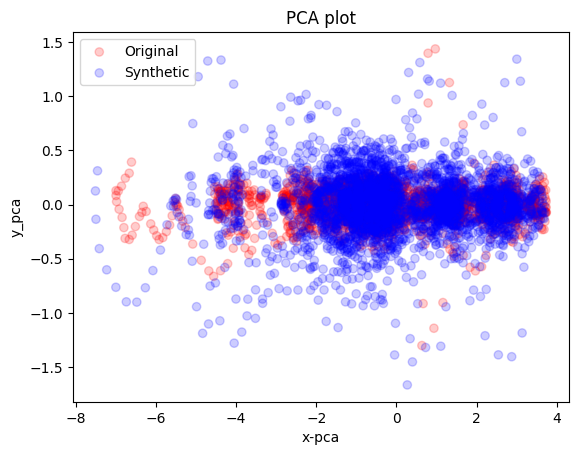

In [5]:
visualization(ori_data=real_windows, generated_data=synthetic_windows, analysis='pca', compare=real_windows.shape[0])

ETTH_1, norm

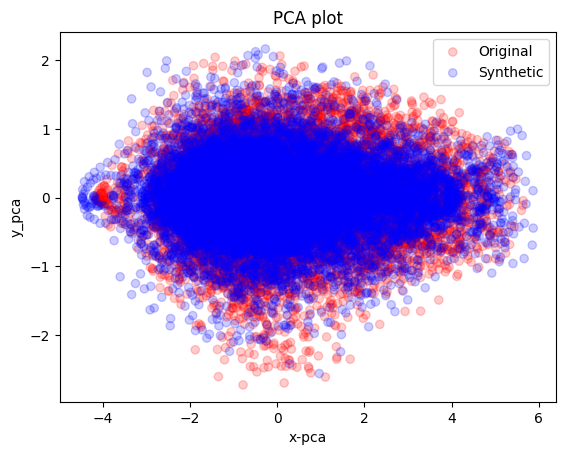

In [5]:
visualization(ori_data=real_windows, generated_data=synthetic_windows, analysis='pca', compare=real_windows.shape[0])

Stock_1 norm

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6614 samples in 0.006s...
[t-SNE] Computed neighbors for 6614 samples in 0.302s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6614
[t-SNE] Computed conditional probabilities for sample 2000 / 6614
[t-SNE] Computed conditional probabilities for sample 3000 / 6614
[t-SNE] Computed conditional probabilities for sample 4000 / 6614
[t-SNE] Computed conditional probabilities for sample 5000 / 6614
[t-SNE] Computed conditional probabilities for sample 6000 / 6614
[t-SNE] Computed conditional probabilities for sample 6614 / 6614
[t-SNE] Mean sigma: 0.085943
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.494919
[t-SNE] KL divergence after 300 iterations: 2.227315


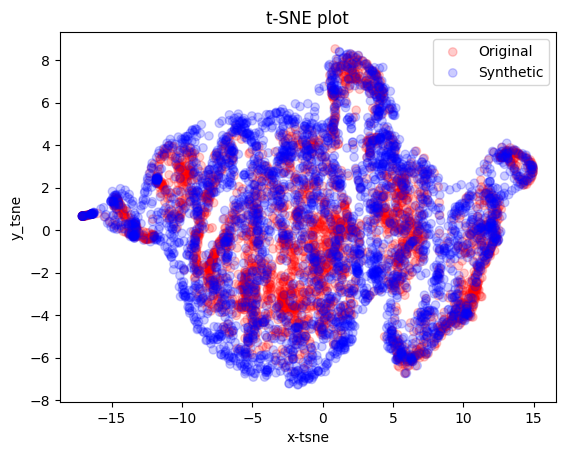

In [6]:
visualization(ori_data=real_windows, generated_data=synthetic_windows, analysis='tsne', compare=real_windows.shape[0])

ETTh_1 norm

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 31338 samples in 0.425s...
[t-SNE] Computed neighbors for 31338 samples in 10.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31338
[t-SNE] Computed conditional probabilities for sample 2000 / 31338
[t-SNE] Computed conditional probabilities for sample 3000 / 31338
[t-SNE] Computed conditional probabilities for sample 4000 / 31338
[t-SNE] Computed conditional probabilities for sample 5000 / 31338
[t-SNE] Computed conditional probabilities for sample 6000 / 31338
[t-SNE] Computed conditional probabilities for sample 7000 / 31338
[t-SNE] Computed conditional probabilities for sample 8000 / 31338
[t-SNE] Computed conditional probabilities for sample 9000 / 31338
[t-SNE] Computed conditional probabilities for sample 10000 / 31338
[t-SNE] Computed conditional probabilities for sample 11000 / 31338
[t-SNE] Computed conditional probabilities for sample 12000 / 31338
[t-SNE] Computed conditional probabilities for s

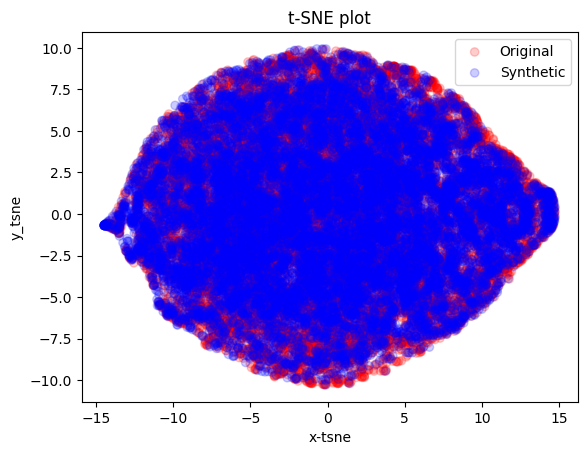

In [6]:
visualization(ori_data=real_windows, generated_data=synthetic_windows, analysis='tsne', compare=real_windows.shape[0])

Stock_1 norm

/tmp/ipykernel_1421098/1541233003.py:147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
/tmp/ipykernel_1421098/1541233003.py:148: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data_ha

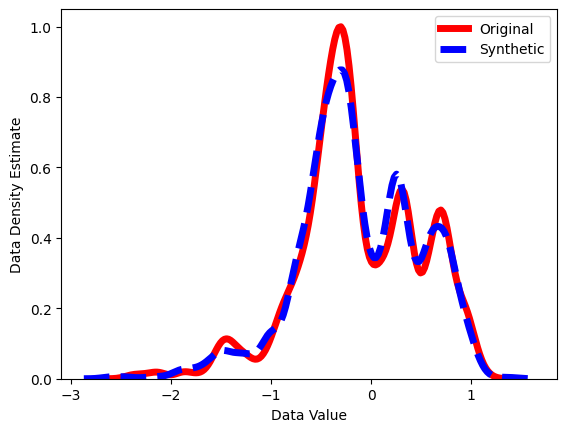

In [7]:
visualization(ori_data=real_windows, generated_data=synthetic_windows, analysis='kernel', compare=real_windows.shape[0])

ETTh_1 norm

/tmp/ipykernel_108558/244809791.py:147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
/tmp/ipykernel_108558/244809791.py:148: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data_hat, h

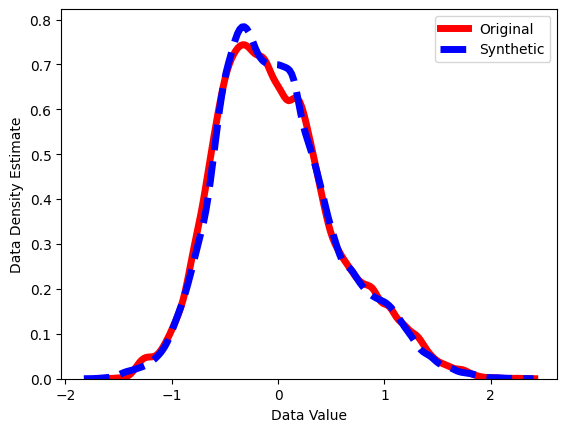

In [7]:
visualization(ori_data=real_windows, generated_data=synthetic_windows, analysis='kernel', compare=real_windows.shape[0])